# Theta model 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = sm.datasets.co2.load_pandas().data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


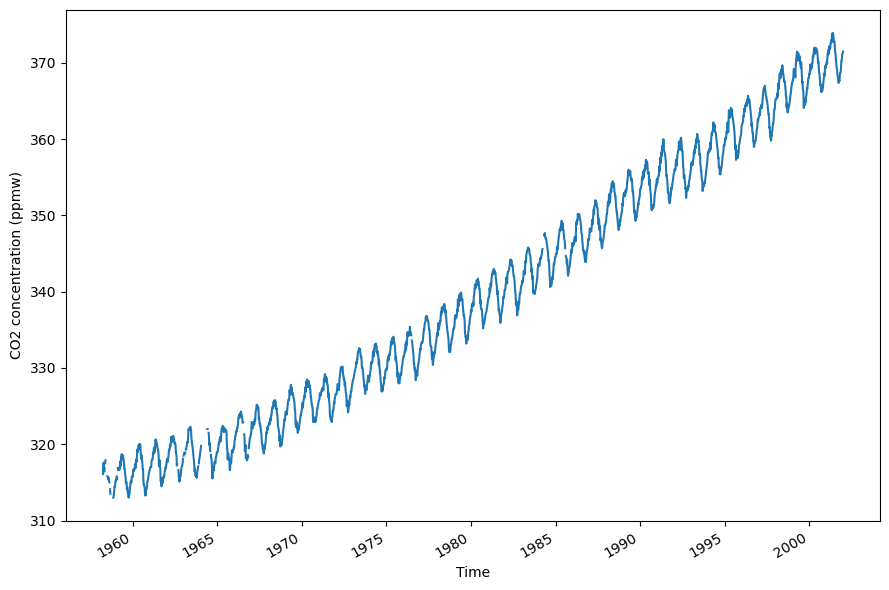

In [4]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
df.isnull().sum()

co2    59
dtype: int64

In [6]:
df = df.interpolate()

df.isnull().sum()

co2    0
dtype: int64

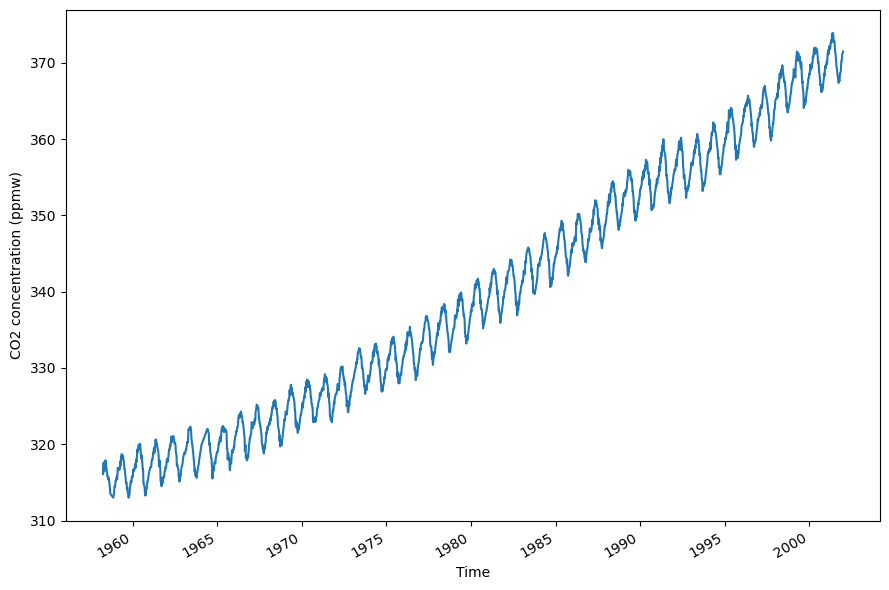

In [7]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

## Modeling 

In [8]:
train = df[:-104]
test = df[-104:]

In [9]:
from statsmodels.tsa.forecasting.theta import ThetaModel

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, period: int, method: str) -> list:
    
    seasonal_steps = int((window/period))
    
    TOTAL_LEN = train_len + horizon

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, TOTAL_LEN, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            
        print(res.summary())

        return pred_theta

In [10]:
TRAIN_LEN = len(train)
HORIZON = len(test)
PERIOD = 52
WINDOW = 52

pred_last_season = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, PERIOD, 'last_season')
pred_theta = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, PERIOD, 'theta')

test = test.copy()

test.loc[:, 'pred_last_season'] = pred_last_season
test.loc[:, 'pred_theta'] = pred_theta

test.head()

                              ThetaModel Results                              
Dep. Variable:                    co2   No. Observations:                 2232
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Fri, 17 Nov 2023   Deseas. Method:         Multiplicative
Time:                        12:04:33   Period:                             52
Sample:                    03-29-1958                                         
                         - 12-30-2000                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    0.02546813102106413
alpha  0.6611560987552895
-------------------------


,co2,pred_last_season,pred_theta
2000-01-08,368.5,367.8,368.688671
2000-01-15,369.0,367.8,368.791990
2000-01-22,369.8,368.3,368.986970
2000-01-29,369.2,369.2,369.111453
2000-02-05,369.1,369.1,369.424445


## Testing triple exponential smoothing 

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, period: int, method: str) -> list:
    
    seasonal_steps = int((window/period))
    
    TOTAL_LEN = train_len + horizon

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, TOTAL_LEN, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            

        return pred_theta
            
    elif method == 'tes':
        pred_tes = []
        
        for i in range(train_len, TOTAL_LEN, window):
            tes = ExponentialSmoothing(
                df[:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()
            
            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

        return pred_tes

In [12]:
pred_tes = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, PERIOD, 'tes')

test.loc[:, 'pred_tes'] = pred_tes

test.head()

,co2,pred_last_season,pred_theta,pred_tes
2000-01-08,368.5,367.8,368.688671,368.923704
2000-01-15,369.0,367.8,368.791990,368.947828
2000-01-22,369.8,368.3,368.986970,369.229240
2000-01-29,369.2,369.2,369.111453,369.630769
2000-02-05,369.1,369.1,369.424445,369.881114


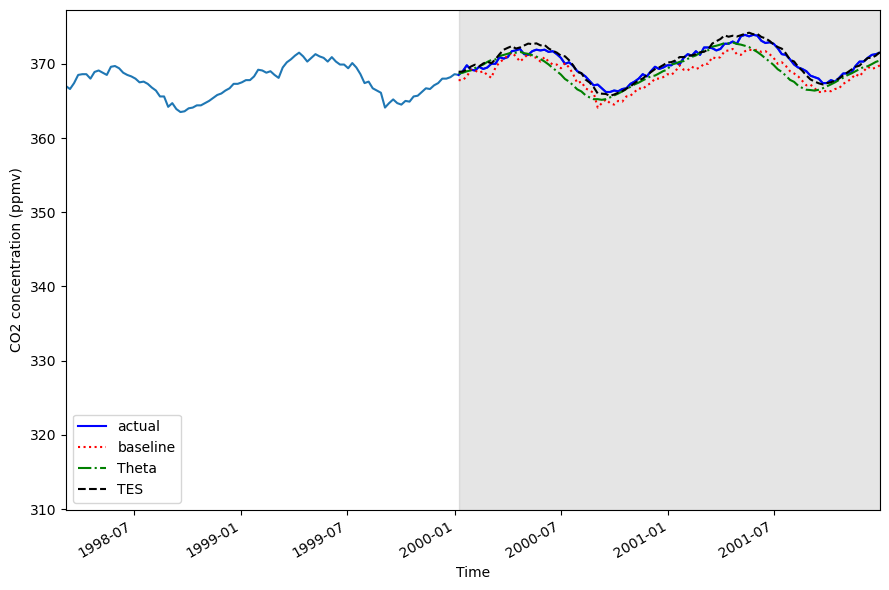

In [14]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.plot(test['co2'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_theta'], 'g-.', label='Theta')
ax.plot(test['pred_tes'], 'k--', label='TES')

ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmv)')
ax.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlim(pd.to_datetime('1998-03-07'), pd.to_datetime('2001-12-29'))

fig.autofmt_xdate()
plt.tight_layout()

## Evaluation 

In [15]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [16]:
mape_baseline = mape(test['co2'], test['pred_last_season'])
mape_theta = mape(test['co2'], test['pred_theta'])
mape_tes = mape(test['co2'], test['pred_tes'])

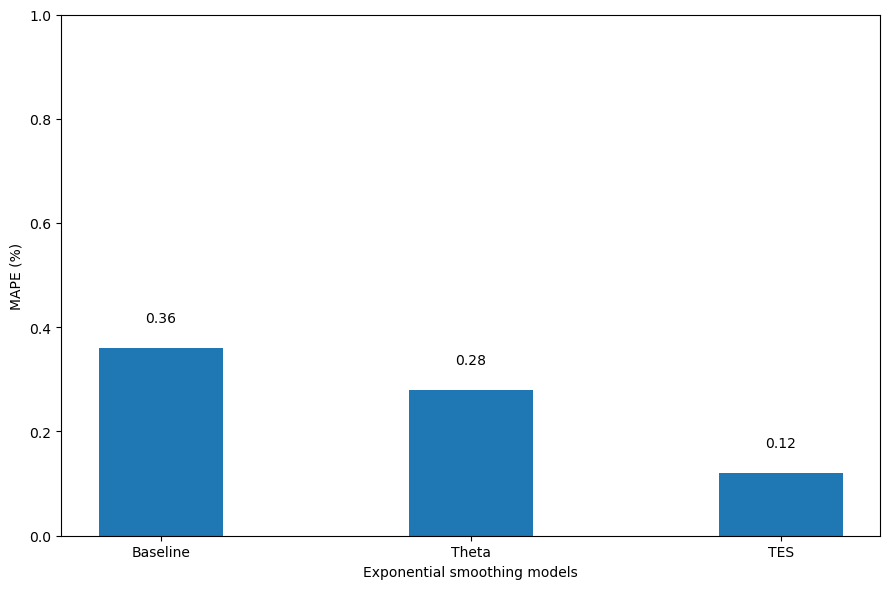

In [17]:
fig, ax = plt.subplots()

x = ['Baseline', 'Theta', 'TES']
y = [mape_baseline, mape_theta, mape_tes]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Exponential smoothing models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

## Testing SARIMA 

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

### Test for stationarity 

In [19]:
ad_fuller_result = adfuller(df['co2'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.03378459745826568
p-value: 0.9612384528286108


In [20]:
df_diff = np.diff(df['co2'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.727522408375888
p-value: 1.3013480157809027e-28


In [21]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False)
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [22]:
min_p = 1
max_p = 3
min_q = 1
max_q = 3

min_P = 1
max_P = 1
min_Q = 1
max_Q = 1

d = 1
D = 0
s = 52

result_df = SARIMA_gridsearch(train, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 9 unique models


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_9827/2832785517.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(all_orders):


  0%|          | 0/9 [00:00<?, ?it/s]

/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using 

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 1)",2082.619775
1,"(3, 3, 1, 1)",2084.924304
2,"(3, 2, 1, 1)",2085.741134
3,"(3, 1, 1, 1)",2090.992012
4,"(1, 3, 1, 1)",2097.393617


In [23]:
SARIMA_model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,0,1,52), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(cov_type='none')

print(SARIMA_model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09842D-01    |proj g|=  1.74068D-01

At iterate    5    f=  5.69366D-01    |proj g|=  3.96268D-02

At iterate   10    f=  5.04431D-01    |proj g|=  9.13720D-02

At iterate   15    f=  4.80872D-01    |proj g|=  2.09010D-02

At iterate   20    f=  4.77882D-01    |proj g|=  1.24753D-02

At iterate   25    f=  4.74182D-01    |proj g|=  3.61866D-03

At iterate   30    f=  4.74101D-01    |proj g|=  2.71876D-04

At iterate   35    f=  4.74091D-01    |proj g|=  9.60492D-04

At iterate   40    f=  4.74045D-01    |proj g|=  7.59344D-03

At iterate   45    f=  4.73998D-01    |proj g|=  8.44404D-04


/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.73995D-01    |proj g|=  2.15454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   2.155D-04   4.740D-01
  F =  0.47399536128093450     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                                  co2   No. Observations:                 2180
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 52)   Log Likelihood               -1033.310
Date:                              Fri, 17 Nov 2023   AIC                         

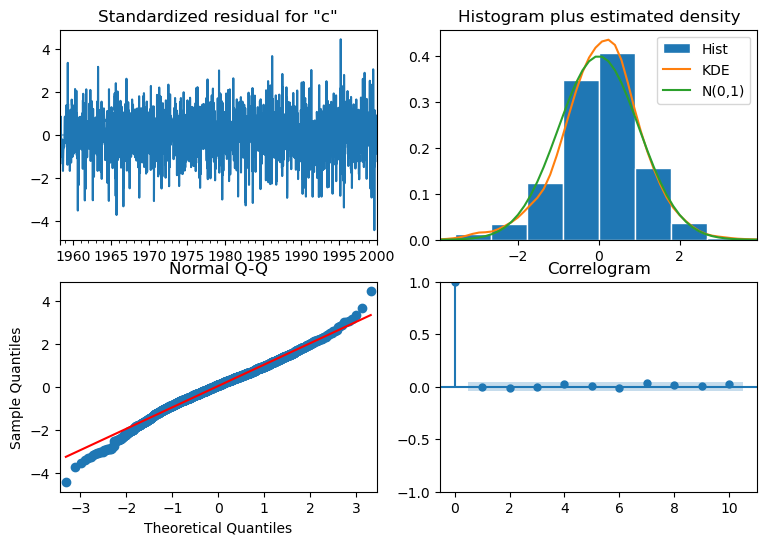

In [24]:
SARIMA_model_fit.plot_diagnostics();

In [25]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


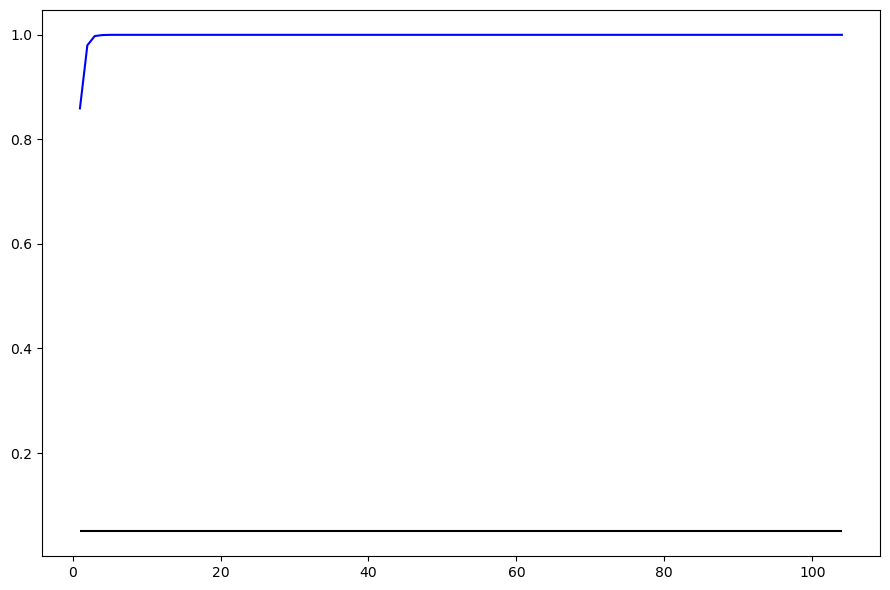

In [26]:
residuals = SARIMA_model_fit.resid

ljung_box_test(residuals, True, 52)

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, period: int, method: str) -> list:
    
    seasonal_steps = int((window/period))
    
    TOTAL_LEN = train_len + horizon

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, total_len, window):
            tm = ThetaModel(endog=df[:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            

        return pred_theta
            
    elif method == 'tes':
        pred_tes = []
        
        for i in range(train_len, total_len, window):
            tes = ExponentialSmoothing(
                df[:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()
            
            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

        return pred_tes

    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(2,1,3), seasonal_order=(1,0,2,52))
            res = model.fit(cov_type='none')
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [28]:
pred_SARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, PERIOD, 'SARIMA')

test.loc[:, 'pred_SARIMA'] = pred_SARIMA

test.head()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97098D-01    |proj g|=  1.40676D-01

At iterate    5    f=  5.61190D-01    |proj g|=  4.02270D-02

At iterate   10    f=  5.03314D-01    |proj g|=  5.71645D-02

At iterate   15    f=  4.76611D-01    |proj g|=  2.00023D-02

At iterate   20    f=  4.73542D-01    |proj g|=  1.11171D-02

At iterate   25    f=  4.70669D-01    |proj g|=  8.30167D-02

At iterate   30    f=  4.69890D-01    |proj g|=  1.45108D-03

At iterate   35    f=  4.69877D-01    |proj g|=  4.11708D-04

At iterate   40    f=  4.69855D-01    |proj g|=  7.97525D-03

At iterate   45    f=  4.69760D-01    |proj g|=  1.34080D-03


/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.69758D-01    |proj g|=  8.27933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   8.279D-04   4.698D-01
  F =  0.46975834922309134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93301D-01    |proj g|=  1.37872D-01

At iterate    5    f=  5.64944D-01    |proj g|=  9.71102D-02

At iterate   10    f=  5.37131D-01    |proj g|=  1.34322D-01

At iterate   15    f=  4.73942D-01    |proj g|=  6.98571D-02

At iterate   20    f=  4.70958D-01    |proj g|=  9.56006D-03

At iterate   25    f=  4.66955D-01    |proj g|=  2.25464D-02

At iterate   30    f=  4.66415D-01    |proj g|=  3.33236D-03

At iterate   35    f=  4.66355D-01    |proj g|=  3.74473D-04

At iterate   40    f=  4.66331D-01    |proj g|=  3.60718D-03

At iterate   45    f=  4.66239D-01    |proj g|=  6.46689D-03


/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.66177D-01    |proj g|=  1.47912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   1.479D-03   4.662D-01
  F =  0.46617668630818454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


,co2,pred_last_season,pred_theta,pred_tes,pred_SARIMA
2000-01-08,368.5,367.8,368.688671,368.923704,368.772976
2000-01-15,369.0,367.8,368.791990,368.947828,368.824059
2000-01-22,369.8,368.3,368.986970,369.229240,369.023764
2000-01-29,369.2,369.2,369.111453,369.630769,369.223507
2000-02-05,369.1,369.1,369.424445,369.881114,369.684348


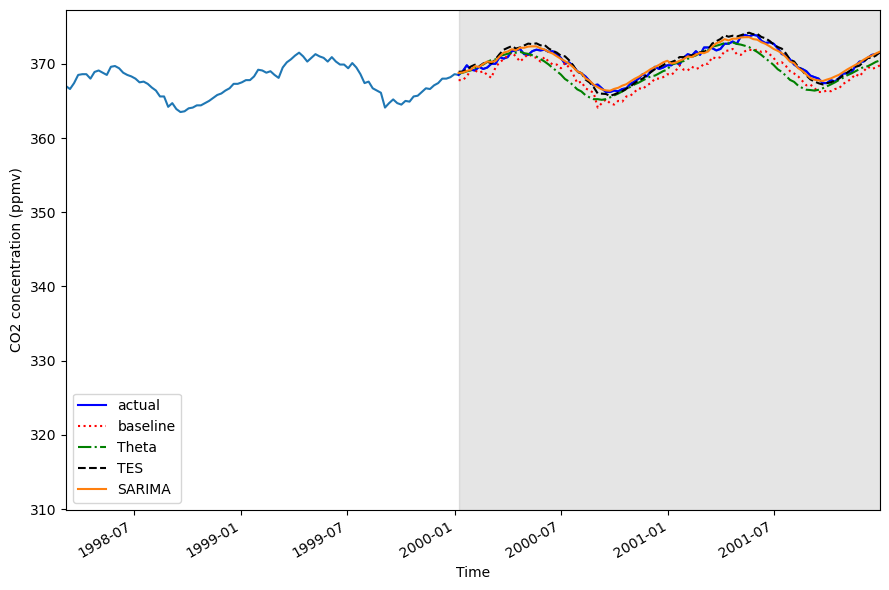

In [30]:
fig, ax = plt.subplots()

ax.plot(df['co2'])
ax.plot(test['co2'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_theta'], 'g-.', label='Theta')
ax.plot(test['pred_tes'], 'k--', label='TES')
ax.plot(test['pred_SARIMA'], label='SARIMA')

ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmv)')
ax.axvspan('2000-01-08', '2001-12-29', color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlim(pd.to_datetime('1998-03-07'), pd.to_datetime('2001-12-29'))

fig.autofmt_xdate()
plt.tight_layout()

In [31]:
mape_SARIMA = mape(test['co2'], test['pred_SARIMA'])

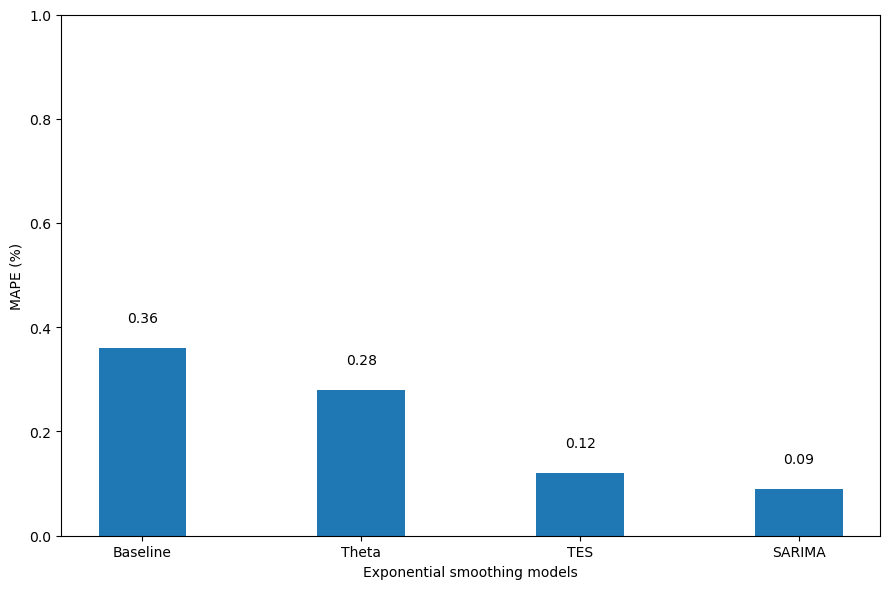

In [32]:
fig, ax = plt.subplots()

x = ['Baseline', 'Theta', 'TES', 'SARIMA']
y = [mape_baseline, mape_theta, mape_tes, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Exponential smoothing models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()